In [25]:
%pylab inline
import pandas as pd
import plotnine as p
p.theme_set(p.theme_classic())

Populating the interactive namespace from numpy and matplotlib


## The effect of Poisson zeros on OLS regression results

In a [previous post](http://www.nxn.se/valent/2018/1/30/count-depth-variation-makes-poisson-scrna-seq-data-negative-binomial) I wrote about the Poisson distribution seeming like a good error model for scRNA-seq counts. This suggests using GLM with Poisson likelihood to analyse your data, as long as the offset due to count depth variation is taken into consideration.

An alternative strategy could be to transform the counts to roughly normal, and perform analysis in that setting. This is effectively what the vast majority of studies do for unsupervised analysis: counts are transformed, then PCA is used to find a low-dimensional representation for further analysis such as clustering.

What if we try to adjust for the count depth variation in a supervised setting assuming Gaussian noise?

A huge benefit of assuming Gaussian noise is that linear regression has an extremely efficient solution, usually referred to as [OLS regression](https://en.wikipedia.org/wiki/Ordinary_least_squares). A couple of years ago I made a [simple Python package]((https://github.com/Teichlab/NaiveDE) `NaiveDE` to perform OLS regression on gene expression matrices. I don't recommend anyone use it for final analysis, indeed I called it "Naive DE" because it is a baseline. Literally every other DE test will be better than it by design, in particular with regards to false positive P-values. (Well maybe not [according to a recent study](https://www.nature.com/articles/nmeth.4612), the `NaiveDE` test should be equivalent to the t-test.) It is nevertheless convenient during exploratory analysis to iterate through models

Alternative and null models are specified by [Patsy formulas](https://patsy.readthedocs.io/en/latest/overview.html), and significance is calculated with a [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test). A [Bonferroni corrected](https://en.wikipedia.org/wiki/Bonferroni_correction) version of the P-value is also reported.

For every gene $ g $ where we have a design matrix $ X $ and observed counts $ y_g $ we look at

$$
y_g = \mathcal{N}\left( \alpha^T_g X, \sigma^2_g \right).
$$

The weights $ \alpha $ are calculated by OLS, and $ \sigma^2 $ is reflected in the residual errors. For flexibility, intercept is optionally part of the design matrix.

### Negative control data

In the negative control 10X dataset from Svensson et al 2017, the only variation in observed expression should (in theory) be due technical effects, in particular the count depth variation. Here we are using 2,000 cells with 24,000 genes. The most common variance stabilizing transformation of scRNA-seq data is $ \log(Y + 1) $, so we will investigate how this affects regression.

If the gene counts are scaled per cells, we would want

$$
\log\left( \frac{y_g}{\text{counts}} \right) = \log(y_g) - 1.0 \cdot \log(\text{counts}) = \mathcal{N}(0, \sigma^2)
$$

We set up a model where the design matrix $ X $ have the log total counts, and an intercept. Ideally the weights for the log counts should be found to be 1, and the intercept 0. Note that in practice we are always using $ \log(y_g + 1) $.

In [3]:
long_counts = pd.read_csv('Svensson%2Fsvensson_long_counts.csv.gz')

In [6]:
counts = long_counts.pivot(index='cell', columns='gene', values='count').fillna(0)

In [12]:
counts = counts[counts.index.str.slice(0, 5) == '20311'].copy()

In [187]:
counts.shape

(2000, 24116)

In [13]:
sample_info = pd.DataFrame(index=counts.index)

In [15]:
import NaiveDE

In [183]:
sample_info['total_count'] = counts.sum(1)

In [189]:
%%time
lr_results = NaiveDE.lr_tests(sample_info, np.log1p(counts.T),
                              alt_model='~ np.log(total_count) + 1', 
                              null_model='~ 1')

CPU times: user 2.98 s, sys: 702 ms, total: 3.68 s
Wall time: 3.35 s


In [193]:
lr_results.pval = lr_results.pval.clip_lower(lr_results.query('pval != 0')['pval'].min())
lr_results.qval = lr_results.qval.clip_lower(lr_results.query('qval != 0')['qval'].min())

The test produces a table with weights from the alternative model, hypothesis test restults.

In [194]:
print(lr_results.sort_values('np.log(total_count)', ascending=False).head(25))

                 Intercept  np.log(total_count)           pval           qval
gene                                                                         
ENSG00000198938  -5.501025             1.080920  3.073563e-294  6.147125e-291
ENSG00000198727  -5.600405             1.041435  3.073563e-294  6.147125e-291
ERCC-00002       -2.999032             1.034389  3.073563e-294  6.147125e-291
ERCC-00136       -4.155633             1.017020  3.073563e-294  6.147125e-291
ERCC-00113       -4.297474             1.010625  3.073563e-294  6.147125e-291
ENSG00000198886  -5.615521             1.010178  2.134557e-266  4.269114e-263
ENSG00000198712  -5.144020             1.005586  3.341643e-168  6.683285e-165
ERCC-00096       -2.740023             0.989442  3.073563e-294  6.147125e-291
ENSG00000210082  -4.357098             0.988333  3.073563e-294  6.147125e-291
ERCC-00046       -3.727992             0.979269  3.073563e-294  6.147125e-291
ERCC-00171       -4.929066             0.976731  3.073563e-294  

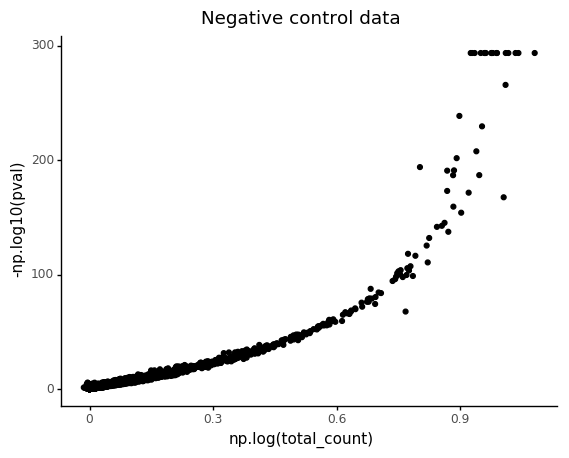

<ggplot: (309405360)>

In [198]:
img = p.qplot('np.log(total_count)', '-np.log10(pval)', lr_results) + p.labs(title='Negative control data')
img.save('1.png', verbose=False)
img

In this plot `np.log(total_count)` does not refer to the value, but _weight_ for this variable. Each dot is a gene rather than droplet. The P-value comes from comparing the model with one that does not consider the depth.

The marjority of genes are found to have gene count weights much smaller than 1.

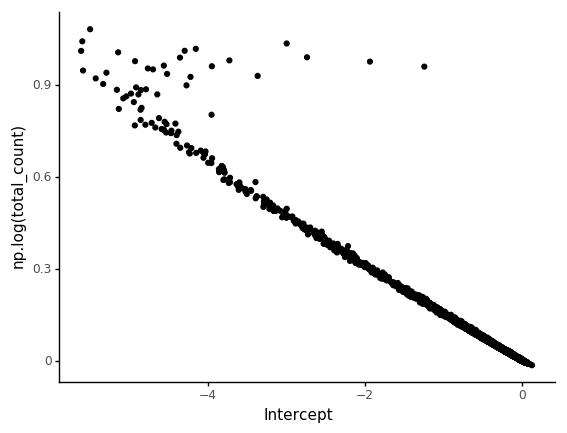

<ggplot: (302850813)>

In [170]:
p.qplot('Intercept', 'np.log(total_count)', lr_results)

It turns out that lowly abundant genes will have delfated total count slopes.

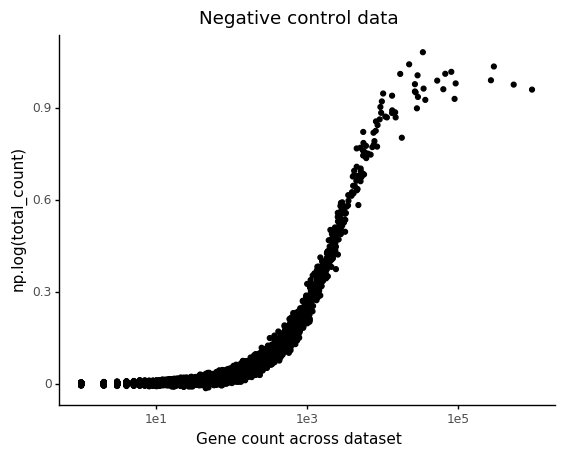

<ggplot: (314489443)>

In [199]:
img = \
p.qplot(counts.sum(0).clip_lower(1), lr_results['np.log(total_count)'],
        log='x') \
    + p.labs(x='Gene count across dataset', y='np.log(total_count)',
             title='Negative control data')
    
img.save('2.png', verbose=False)
img

In [197]:
top_results = \
lr_results \
    .sort_values('np.log(total_count)', ascending=False) \
    .groupby(pd.cut(lr_results['np.log(total_count)'], 6)) \
    .head(2)
    
print(top_results)

                 Intercept  np.log(total_count)           pval           qval
gene                                                                         
ENSG00000198938  -5.501025             1.080920  3.073563e-294  6.147125e-291
ENSG00000198727  -5.600405             1.041435  3.073563e-294  6.147125e-291
ERCC-00108       -4.274218             0.898010  2.769279e-239  5.538557e-236
ENSG00000197971  -4.915248             0.891393  2.249046e-202  4.498092e-199
ENSG00000167526  -4.402066             0.707681   1.596769e-84   3.193539e-81
ENSG00000105372  -4.266704             0.701855   4.679675e-85   9.359351e-82
ENSG00000008988  -3.393418             0.529772   5.607786e-50   1.121557e-46
ENSG00000166681  -3.253979             0.525875   1.905170e-48   3.810339e-45
ENSG00000105640  -2.249544             0.350815   1.185224e-28   2.370448e-25
ENSG00000105290  -2.155855             0.350446   2.506105e-26   5.012210e-23
ENSG00000241343  -1.100482             0.168054   9.412177e-13  

In [110]:
xx = np.linspace(np.log(sample_info.total_count.min()),
                 np.log(sample_info.total_count.max()))

In [134]:
def linres(gene):
    yy = \
    top_results.loc[gene, 'np.log(total_count)'] * xx \
        + top_results.loc[gene, 'Intercept']

    yy = np.exp(yy)
    return yy

In [158]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

We can look at a few examples of genes with different count depth weights

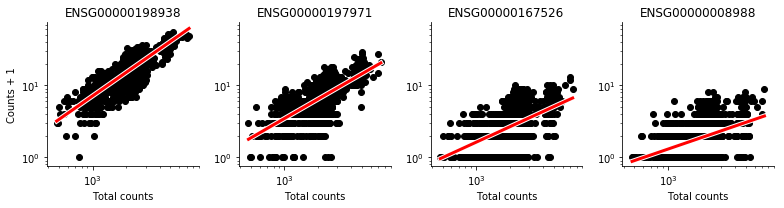

In [181]:
figsize(11, 3)

plt.subplot(141)
plt.loglog()
gene = 'ENSG00000198938'
plt.scatter(sample_info.total_count, counts[gene] + 1, c='k');
yy = linres(gene)
plt.plot(np.exp(xx), yy, c='w', lw=5)
plt.plot(np.exp(xx), yy, c='r', lw=3)
plt.title(gene)
plt.ylabel('Counts + 1')
plt.xlabel('Total counts')
ax = plt.gca()

plt.subplot(142, sharey=ax)
plt.loglog()
gene = 'ENSG00000197971'
plt.scatter(sample_info.total_count, counts[gene] + 1, c='k');
yy = linres(gene)
plt.plot(np.exp(xx), yy, c='w', lw=5)
plt.plot(np.exp(xx), yy, c='r', lw=3)
plt.title(gene)
plt.xlabel('Total counts')

plt.subplot(143, sharey=ax)
plt.loglog()
gene = 'ENSG00000167526'
plt.scatter(sample_info.total_count, counts[gene] + 1, c='k');
yy = linres(gene)
plt.plot(np.exp(xx), yy, c='w', lw=5)
plt.plot(np.exp(xx), yy, c='r', lw=3)
plt.title(gene)
plt.xlabel('Total counts')

plt.subplot(144, sharey=ax)
plt.loglog()
gene = 'ENSG00000008988'
plt.scatter(sample_info.total_count, counts[gene] + 1, c='k');
yy = linres(gene)
plt.plot(np.exp(xx), yy, c='w', lw=5)
plt.plot(np.exp(xx), yy, c='r', lw=3)
plt.title(gene)
plt.xlabel('Total counts')

ax.set_ylim(0.76, 75);

plt.tight_layout()
plt.savefig('3.png', bbox_inches='tight')

From this, it is clear that increased observations on the low count values, in particular 0, are responsible for decrease in the total count weight.